<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Executive-Summary" data-toc-modified-id="Executive-Summary-1">Executive Summary</a></span><ul class="toc-item"><li><span><a href="#Importing-the-Libraries" data-toc-modified-id="Importing-the-Libraries-1.1">Importing the Libraries</a></span></li><li><span><a href="#Reading-the-data" data-toc-modified-id="Reading-the-data-1.2">Reading the data</a></span></li><li><span><a href="#Some-basic-Cleaning-(-EDA-is-done-in-another-notebook)" data-toc-modified-id="Some-basic-Cleaning-(-EDA-is-done-in-another-notebook)-1.3">Some basic Cleaning ( EDA is done in another notebook)</a></span><ul class="toc-item"><li><span><a href="#Saving-the-cleaned-data-as-a-csv" data-toc-modified-id="Saving-the-cleaned-data-as-a-csv-1.3.1">Saving the cleaned data as a csv</a></span></li></ul></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2">Modeling</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Setting-up-the-variables-for-DBScan" data-toc-modified-id="Setting-up-the-variables-for-DBScan-2.0.1">Setting up the variables for DBScan</a></span></li><li><span><a href="#Scaling-the-variables-and-fitting/transforming-the-model" data-toc-modified-id="Scaling-the-variables-and-fitting/transforming-the-model-2.0.2">Scaling the variables and fitting/transforming the model</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3">Conclusion</a></span></li></ul></div>

# Executive Summary

We pulled data multiple times a day from the Tom Tom API to be able to get live data about road and traffic conditions in the city. After cleaning and doing basic EDA, in order to validate the efficiency of routing given by Tom Tom we decided to use an Unsupervised Model since we did not have a target variable. We used the DBScan Clustering Algorithm to cluster high density traffic areas in the city. DBSCan is an UNSUPERVISED clustering Algorithm, so there is no true way to evaluate it. The mechanism for clustering is that the neighborhood of a given radius has to contain  a minimum number of points.  Therefore the parameters of the model are the radius  and the number of points included in the cluster. For our modeling we utilized the coordinates of traffic incidents. We tried different values for the eps and minimum number of observations to get the best value counts for the clusters and minimizing the outliers. We also tried to get the best value for the Silhouette Score 
Being that there is no way to really evaluate the model, we still used pseudo metrics for our evaluation purposes.
The Silhouette Score shows the proximity and density of clusters and has values from -1 to 1. We chose the Silhouette Score for our model because it showed us the relationship between our clusters. 

## Importing the Libraries

In [483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from datetime import time

%matplotlib inline

## Reading the data

In [484]:
df = pd.read_csv('./data/df.csv')

In [485]:
df.head()

,coord,day,delay,description,end_date,from,geometry,hour,id,latitude,length,longitude,to
0,"{'x': -73.9743662, 'y': 40.7783631}",Tuesday,0,4,2020-02-25 05:43:59+00:00,Central Park W,POINT (-73.97436620000001 40.7783631),5.0,TTR5158489041614001,40.778363,272,-73.974366,Broadway
1,"{'x': -73.9803143, 'y': 40.7544967}",Thursday,1,2,2020-02-13 17:41:00+00:00,5th Ave (50th St),POINT (-73.9803143 40.7544967),17.0,TTL5159643158406005,40.754497,299,-73.980314,Park Ave (E 50th St)
2,"{'x': -73.9851146, 'y': 40.7730232}",Thursday,1,2,2020-02-13 17:41:00+00:00,Broadway,POINT (-73.9851146 40.7730232),17.0,TTL5157911932806006,40.773023,487,-73.985115,Central Park W
3,"{'x': -73.985892, 'y': 40.7671613}",Tuesday,0,4,2020-03-31 04:43:59+00:00,W 57th St (7th Ave),POINT (-73.98589200000001 40.7671613),4.0,TTR5159066100004001,40.767161,78,-73.985892,W 50th St (7th Ave)
4,"{'x': -73.9823474, 'y': 40.7537168}",Thursday,1,2,2020-02-13 17:41:00+00:00,6th Ave/Avenue of the Americas (W 48th St),POINT (-73.98234739999999 40.7537168),17.0,TTL5159643158406004,40.753717,421,-73.982347,Park Ave (E 48th St)


## Some basic Cleaning ( EDA is done in another notebook)

In [487]:
df.shape

(1247, 13)

In [491]:
df.dropna(inplace=True)

In [492]:
df.duplicated().sum()

18

In [493]:
df = df.drop_duplicates(keep = 'first')

In [494]:
df.shape

(1229, 13)

In [495]:
df.isnull().sum()

coord          0
day            0
delay          0
description    0
end_date       0
from           0
geometry       0
hour           0
id             0
latitude       0
length         0
longitude      0
to             0
dtype: int64

### Saving the cleaned data as a csv

In [496]:
df.to_csv('./data/df.csv', index = False)

Setting the variable 'description' as numbers to reflect the severity of the traffic condition. There are 11 broad categories, which included one lane closed, two lanes closed, left lane closed, right lane closed, slow traffic, maintenance work, accident, queuing traffic, stationary traffic, roadworks, construction work, major event, 

In [497]:
df['description'].unique()

array([ 4,  2,  5,  1,  3,  9, 12,  6,  8, 13, 10,  7, 14, 15, 11])

In [498]:
df['description'] = df['description'].map({'roadworks':4, 'slow traffic':2, 'closed':5, 'one lane closed':1,
       'queuing traffic':3, 'stationary traffic':9, 'major roadworks':12,
       'right lane closed':6, 'lane closed':8, 'construction work':13,
       'maintenance work':10, 'left lane closed':7, 'accident':14, 'major event':15,
       'two lanes closed':11})

/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [499]:
df.head()

,coord,day,delay,description,end_date,from,geometry,hour,id,latitude,length,longitude,to
0,"{'x': -73.9743662, 'y': 40.7783631}",Tuesday,0,NaN,2020-02-25 05:43:59+00:00,Central Park W,POINT (-73.97436620000001 40.7783631),5.0,TTR5158489041614001,40.778363,272,-73.974366,Broadway
1,"{'x': -73.9803143, 'y': 40.7544967}",Thursday,1,NaN,2020-02-13 17:41:00+00:00,5th Ave (50th St),POINT (-73.9803143 40.7544967),17.0,TTL5159643158406005,40.754497,299,-73.980314,Park Ave (E 50th St)
2,"{'x': -73.9851146, 'y': 40.7730232}",Thursday,1,NaN,2020-02-13 17:41:00+00:00,Broadway,POINT (-73.9851146 40.7730232),17.0,TTL5157911932806006,40.773023,487,-73.985115,Central Park W
3,"{'x': -73.985892, 'y': 40.7671613}",Tuesday,0,NaN,2020-03-31 04:43:59+00:00,W 57th St (7th Ave),POINT (-73.98589200000001 40.7671613),4.0,TTR5159066100004001,40.767161,78,-73.985892,W 50th St (7th Ave)
4,"{'x': -73.9823474, 'y': 40.7537168}",Thursday,1,NaN,2020-02-13 17:41:00+00:00,6th Ave/Avenue of the Americas (W 48th St),POINT (-73.98234739999999 40.7537168),17.0,TTL5159643158406004,40.753717,421,-73.982347,Park Ave (E 48th St)


# Modeling

### Setting up the variables for DBScan
We decided to use the latitude and longitude of road incidents as inputs for our clustering model

In [500]:
df_db = df[['latitude', 'longitude']]

In [501]:
df_db

,latitude,longitude
0,40.778363,-73.974366
1,40.754497,-73.980314
2,40.773023,-73.985115
3,40.767161,-73.985892
4,40.753717,-73.982347
...,...,...
1242,40.736326,-73.895931
1243,40.742871,-73.904979
1244,40.743519,-73.904130
1245,40.742552,-73.901837


### Scaling the variables and fitting/transforming the model

In [502]:
ss = StandardScaler()
X_scaled_live = ss.fit_transform(df_db)

We tried different values for the eps and minimum samples to get the best value counts for the clusters and minimizing the outliers. We also tried to get the best value for the Silhouette Score as well. The DBScan is an unsupervised clustering algorithm so cannot be evaluated using a metric. The silhouette score is a pseudo metric to gauge the accuracy of the model. 

In [541]:
dbscan = DBSCAN(eps = 0.3, min_samples=9)
dbscan.fit(X_scaled_live)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=9, n_jobs=None, p=None)

In [542]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4}

In [543]:
silhouette_score(X_scaled_live, dbscan.labels_)

0.4060784077197917

In [544]:
df_db['cluster'] = dbscan.labels_

/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


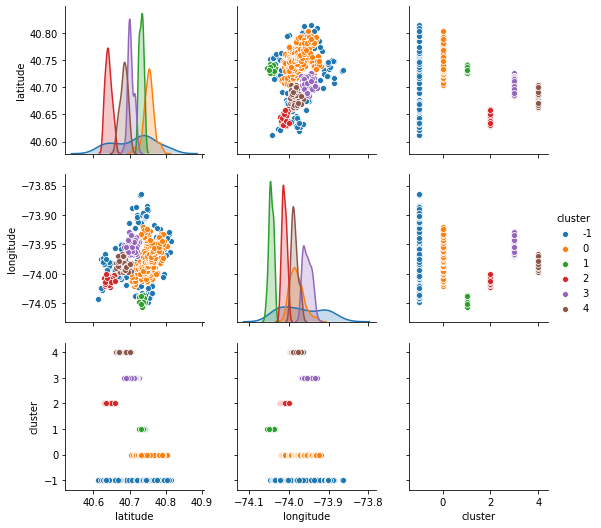

In [545]:
sns.pairplot(df_db, hue ='cluster');

Looking at the percentages of our data in each cluster.

In [546]:
df_db['cluster'].value_counts(normalize = True)

 0    0.737185
 3    0.093572
-1    0.073230
 4    0.058584
 2    0.022783
 1    0.014646
Name: cluster, dtype: float64

# Conclusion
The DBScan Clustering Algorithm does a decent job of clustering the traffic incident areas. Since it is an Unsupervised Model and it is being utilized for visual purposes only, a Silhouette score of 0.40 will suffice. Therefore, we are satisfied with our final model.